## L2 norm estimation of the equivalent layer parameters

This notebook evaluates the predicted data obtained by an equivalent layer located at a specific depth.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from coord import GGS
from normal_grav import Norm_Grav
from equiv_layer import EqLayer
from carto_map_plot import point_map
from carto_map_plot import grid_map
import config_style_plot as style

# Redefining functions
geodetic2cartesian = GGS().geodetic2cartesian
rotation_matrix = GGS().rotation_matrix
closedform = Norm_Grav().closedform
# Plot style
style.plot_params()

In [2]:
def L1_estim(rcl, pcl, Acc_l, it_max):
    for i in range(it_max):
#         print i
        res = rcl - np.dot(Acc_l, pcl)
        W = np.dot(Acc_l.T, np.diag(1./(np.abs(res)+1e-10)) )
        pcl = np.linalg.solve(np.dot(W, Acc_l), np.dot(W, rcl))
    return pcl

In [3]:
# IMPORTING EIGEN FILE
header=['LONG', 'LAT', 'GRAV']
path = '../data/ICGEM/Guanabara_'
uf = 'RJ'
name_bdg = '0.001deg.gdf'
eigen = pd.read_csv('{p}{ne}'.format(p=path,ne=name_bdg), sep='\s+',names=header, skiprows=34)
# bdg
alt = np.zeros_like(eigen.LONG.values) + 3000.
gamma = closedform(alt, eigen.LAT.values)

In [4]:
# Obtaining short wavelength signals
disturb = eigen.GRAV.values - gamma

data = {'LONG':eigen.LONG.values-360., \
        'LAT':eigen.LAT.values, \
        'ALT':alt, \
        'GRAV':eigen.GRAV.values, \
        'GAMMA':gamma, \
        'DIST':disturb}
df = pd.DataFrame(data)
df

,LONG,LAT,ALT,GRAV,GAMMA,DIST
0,-43.500,-22.53,3000.0,977898.310673,977865.559417,32.751256
1,-43.499,-22.53,3000.0,977898.506486,977865.559417,32.947068
2,-43.498,-22.53,3000.0,977898.698916,977865.559417,33.139499
3,-43.497,-22.53,3000.0,977898.887893,977865.559417,33.328476
4,-43.496,-22.53,3000.0,977899.073348,977865.559417,33.513931
...,...,...,...,...,...,...
443526,-42.844,-23.20,3000.0,977903.753240,977908.859455,-5.106215
443527,-42.843,-23.20,3000.0,977903.805624,977908.859455,-5.053831
443528,-42.842,-23.20,3000.0,977903.859254,977908.859455,-5.000202
443529,-42.841,-23.20,3000.0,977903.914140,977908.859455,-4.945315


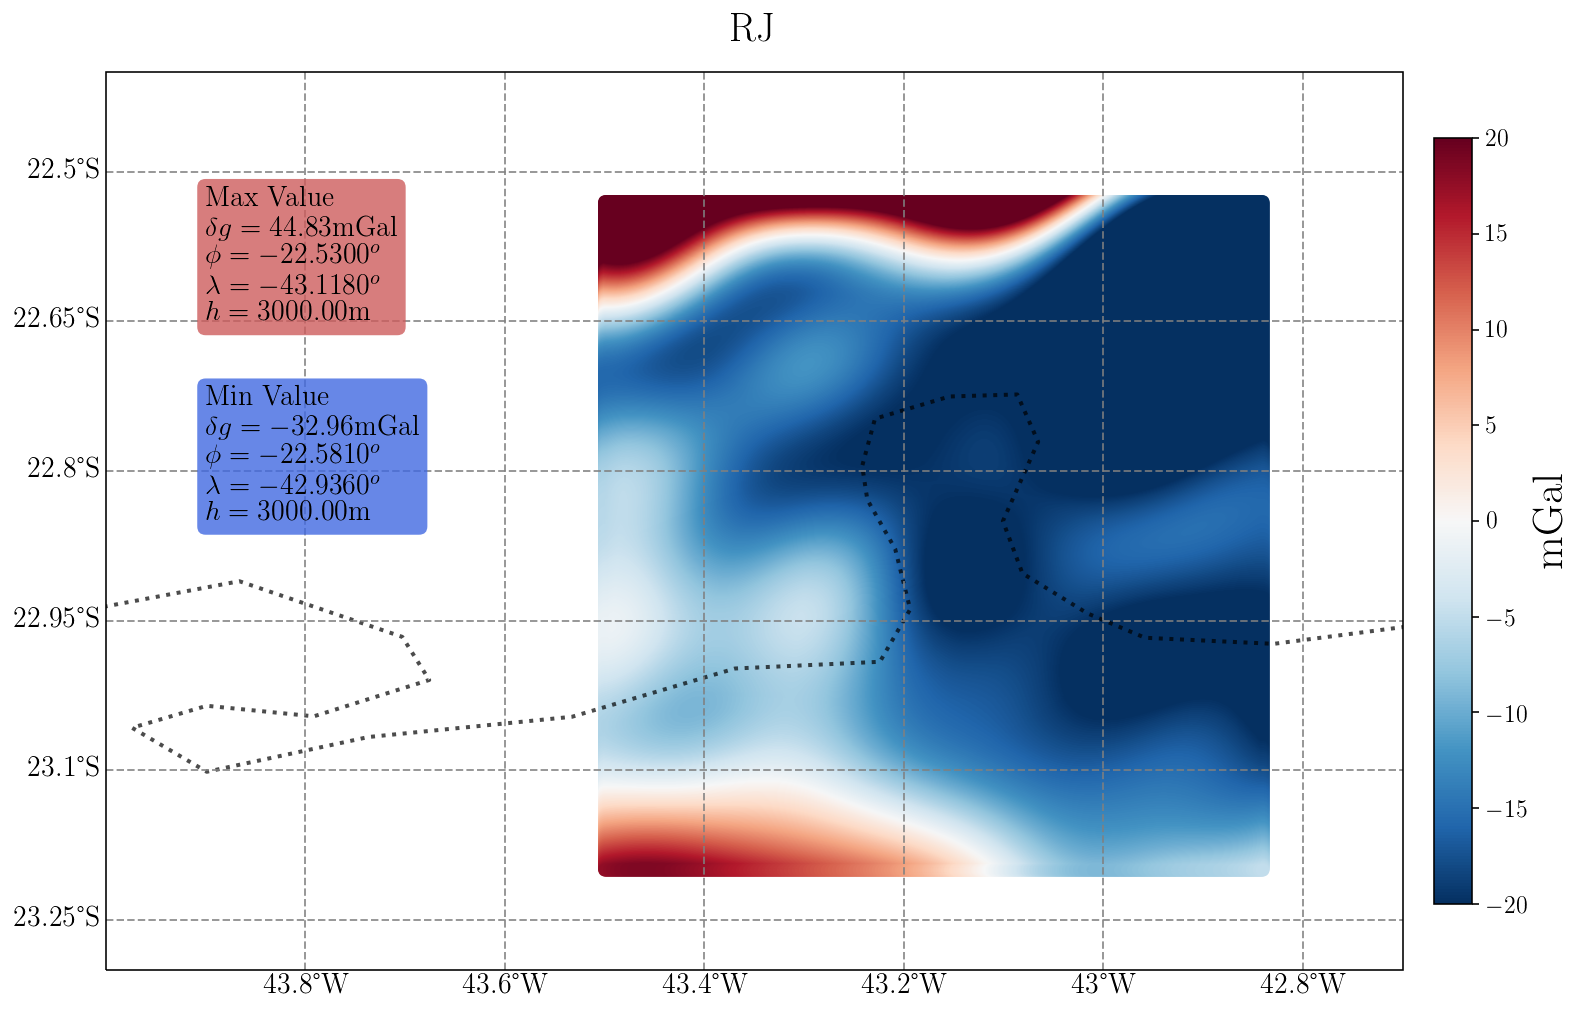

In [5]:
point_map(df.LONG, df.LAT, df.ALT, df.DIST, uf, fig_size=(14.,16.), region=[-44.,-42.7,-23.3,-22.4], \
          sign=(-43.9,-43.9,-22.65,-22.85), shrink=0.44, lim_val=(True, 20.))

In [6]:
# grid_map(df.LONG, df.LAT, df.ALT, df.DIST, uf, fig_size=(14.,16.), region=[-44.,-42.7,-23.3,-22.4], \
#           sign=(-43.9,-43.9,-22.65,-22.85), shrink=0.44, lim_val=(True, 20.))

### Calculating rotation matrices and Cartesian coordinates

In [ ]:
# Calculating Cartesian coordinates
x, y, z = geodetic2cartesian(df.LONG, df.LAT, df.ALT)
R = np.array(rotation_matrix(df.LONG, df.LAT))

## Estimating the first set of point-mass parameters

In [ ]:
pc = []
hc = []
indc = []
xc = []
yc = []
zc = []
Rc = []
rabs_max = []
taur = 1e-11 #1e-5 #0.05
tauc = 1e-3
it_max_l1 = 5
latc = []
lonc = []

## Iteração 1 - L2 norm

In [ ]:
indl = np.arange(disturb.size)
# mi_c = 1e-5
mi_c = 1e-30
hcl = 3000. #5000. #14200. # 20000. #800. #1000.
print(hcl, type(indl)) #indl

In [ ]:
rcl = disturb[indl]
xcl = x[indl]
ycl = y[indl]
zcl = z[indl]

latcl = df.LAT[indl]
loncl = df.LONG[indl]

In [ ]:
Rcl = R[:, indl]

In [ ]:
# Calculo de Acc_l
hlay = np.zeros(indl.size) - hcl
xlay, ylay, zlay = geodetic2cartesian(loncl, latcl, hlay)
Lay = EqLayer(df.LONG, df.LAT, np.zeros_like(df.LONG)-hcl)
layer = Lay.build_layer(xlay, ylay, zlay)
Acc_l = Lay.designMat(xcl, ycl, zcl, Rcl, layer)
print(Acc_l.shape)

In [ ]:
H = np.dot(Acc_l.T, Acc_l)
# H += mi_c*np.trace(H)*np.identity(indl.size)
H += (mi_c*np.trace(H)*np.identity(indl.size))/indl.size

In [ ]:
p_L2 = np.linalg.solve(H, np.dot(Acc_l.T, rcl))
print(p_L2.size)
# p_L1 = L1_estim(rcl, p_L2, Acc_l, 5)

In [ ]:
rcl -= np.dot(Acc_l, p_L2)
# print rcl[:50]

In [ ]:
rabs_max_l = np.max(np.abs(rcl))
rabs_max_l

In [ ]:
pc.append(p_L2)
hc.append(hcl)
indc.append(indl)
xc.append(xcl)
yc.append(ycl)
zc.append(zcl)
Rc.append(Rcl)
latc.append(latcl)
lonc.append(loncl)

In [ ]:
rabs_max.append(rabs_max_l)

In [ ]:
rc = rcl[:] #r1
print(np.max(np.abs(rc)))

In [ ]:
point_map(df.LONG, df.LAT, df.ALT, rc, uf, fig_size=(12.,14.), region=[-45.5,-40.9,-23.6,-20.4], \
         sign=(-45.3,-45.3,-21.3,-22), residual=True, lim_val=(True, 1e-5))

In [ ]:
grid_map(df.LONG, df.LAT, df.ALT, df.DIST, uf, fig_size=(12.,14.), region=[-45.5,-40.9,-23.6,-20.4], \
         sign=(-45.3,-45.3,-21.3,-22))#, lim_val=(True, 40.))

In [ ]:
grid_map(df.LONG, df.LAT, df.ALT, np.dot(Acc_l, p_L2), uf, fig_size=(12.,14.), \
          region=[-45.5,-40.9,-23.6,-20.4], sign=(-45.3,-45.3,-21.3,-22))#, lim_val=(True, 40.))

In [ ]:
print(len([value for value in rc if value > 1e-5]))
print([value for value in rc if value > 1e-5])

In [ ]:
new_data = {'LONG':eigen.LONG.values-360., \
        'LAT':eigen.LAT.values, \
        'ALT':alt, \
        'GRAV':eigen.GRAV.values, \
        'GAMMA':gamma, \
        'DIST':disturb, \
        'RHO':p_L2, \
        'RESID':rc}
df = pd.DataFrame(new_data)
df

In [ ]:
print(df.RESID.min(), df.RESID.max())